In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

Make undesired columns

In [20]:
def import_csv():
    undesired1 = pd.read_csv('undesired_outcome_1.csv')
    undesired2 = pd.read_csv('undesired_outcome_2.csv')
    completelog = pd.read_csv('BPI Challenge 2018_pre-processed.csv')
    completelog['undesired1'] = (completelog['Case ID'].isin(undesired1['Case ID'])) 
    completelog['undesired2'] = (completelog['Case ID'].isin(undesired2['Case ID'])) 
    completelog['undesired1&2'] = (completelog['undesired1']) | (completelog['undesired2'])
    df = completelog
    return df

In [21]:
df=import_csv()

In [22]:
'redistribution' in list(df)

False

get cuttoff point

In [23]:
def get_cutt_off(cutt_off, dataframe):
    dataframe['Complete Timestamp'] = pd.to_datetime(dataframe['Complete Timestamp'])
    dataframe['index'] = dataframe.index
    group = dataframe.groupby('Case ID')
    df1 = group.head(1)
    #get first index
    start_idx = dict([(value,key) for key,value in df1[['index','Case ID']].to_dict()['Case ID'].items()])

    if isinstance(cutt_off, int):
        #get last index
        end_idx = dict(group.nth(cutt_off)['index'])

    if isinstance(cutt_off, str):
        #get last index
        end_idx = dataframe[dataframe[cutt_off] == 1].groupby('Case ID').head(1)[['Case ID', 'index']].to_dict()['Case ID']
        end_idx = dict([(value,key) for key,value in end_idx.items()])

    #make dict with {caseid:(startindex,cuttoff index)}
    indices = {case:(start_idx[case], end_idx[case]) for case in list(end_idx.keys())}        

    dict1 = {}
    keys = list(dataframe[:1].to_dict('list').keys())
    for case in list(end_idx.keys()):
        dict_i = dataframe[indices[case][0]:indices[case][1]].to_dict('list')
        for key in keys:
            if len(dict1)<len(keys):
                dict1[key]=dict_i[key]
            else:
                dict1[key].extend(dict_i[key])  
    
    dataframe_cuttoff = pd.DataFrame.from_dict(dict1, orient='columns')
    
    dataframe_cuttoff = get_duration_till(dataframe_cuttoff) 
    return dataframe_cuttoff

        

In [24]:
def get_duration_till(dataframe):
    group = dataframe.groupby('Case ID')
    time1 = group.head(1)[['Case ID', 'Complete Timestamp']].set_index('Case ID').to_dict()['Complete Timestamp']
    time2 = group.tail(1)[['Case ID', 'Complete Timestamp']].set_index('Case ID').to_dict()['Complete Timestamp']
    time = {case:abs(time2[case]-time1[case]).days for case in time2.keys()}
    dataframe['duration'] = dataframe['Case ID'].map(time)
    return dataframe
    

(array([   22.,  2945., 12711., 13269.,  5237.,  3006.,  1894.,  1142.,
          888.,   585.]),
 array([ 24. ,  31.6,  39.2,  46.8,  54.4,  62. ,  69.6,  77.2,  84.8,
         92.4, 100. ]),
 <a list of 10 Patch objects>)

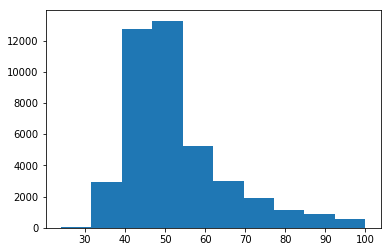

In [25]:
plt.hist(df['Case ID'].value_counts())

Merge dfs & save

In [26]:
def get_df(cutt_off):
    '''Here we flatten & merge the dataframes'''
    dataframe = get_cutt_off(cutt_off,import_csv())
    
    activities= list(set(dataframe['activity']))
    dataframe = pd.concat([dataframe,pd.get_dummies(dataframe['activity'])], axis=1)

    dataframe= dataframe.fillna(0)  #zet NaNs om in 0, dit maakt summen makkelijker.
    
    dummies = ['(case) department', 'doctype', 'subprocess']
    dataframe = pd.get_dummies(data=dataframe, columns=dummies)

    summable = ['(case) basic payment','(case) greening','(case) redistribution', '(case) rejected','(case) risk_factor','(case) selected_manually',
                '(case) selected_random', '(case) selected_risk', '(case) small farmer','(case) young farmer', 'success']
    penalties=  [col for col in list(dataframe) if 'penalty' in col]


    dummie_cols = [col for col in list(dataframe) if 'doctype' in col]
    dummie_cols.extend([col for col in list(dataframe) if 'department' in col])
    dummie_cols.extend([col for col in list(dataframe) if 'subproces' in col])
    summable.extend(activities)
    summable.extend(penalties)
    summable.extend(dummie_cols)


    drop=['Activity', 'Resource', 'Variant', 'Variant index', 'activity','(case) area', '(case) program-id','docid','eventid','note','concept:name','(case) application', 'lifecycle:transition','(case) applicant']
    dataframe=dataframe.drop(drop,axis=1)


    rest = list(set(list(dataframe))-set(summable)) #de kolommen die niet gesumt moeten worden. Maar dus waarvan de laatste entries moeten worden gepakt. 
    
    group = dataframe.groupby('Case ID')
    df_summable = group[summable].agg('sum')
    df_not = group[rest].tail(1)
    
    df_final = pd.merge(df_not, df_summable, on='Case ID')
    df_final = df_final.drop(['Case ID','(case) basic payment','Complete Timestamp', '(case) greening', '(case) rejected', '(case) risk_factor'],axis=1)
    #clean up column names
    df_final.columns = [column[7:] if '(case)' in column else column for column in list(df_final)]
    
    df_final.to_csv(f'{cutt_off}_event_cuttoff.csv')
    return df_final

In [27]:
for item in [10,15,20,25,30,35,40]:
    print(item)
    get_df(item)

10
15
20
25
30
35
40
